#### This figure compares metrics of population activity from awake-resting vs. anesthetized

In [1]:
import os
import sys
import json
import time
from datetime import date
import gspread
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import integrate, signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

In [8]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

### Load subjects from file

In [9]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [10]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
        ## Load units stats file, if exists ##
        fn_units_info = os.path.join(mdata['exp'].data_folder, 'evoked_data', 'units_info_' + group + '.csv')
        fn_units_stats = os.path.join(mdata['exp'].data_folder, 'evoked_data', 'units_info_wresp_' + group + '.csv')
        if os.path.exists(fn_units_stats):
            mdata['units_info_df'] = pd.read_csv(fn_units_info)
            mdata['units_stats_df'] = pd.read_csv(fn_units_stats)
        else:
            print('  {} not found'.format(fn_units_stats))
        print('')
    print('')

MOs_superficial

 546655
Experiment type: electrical and sensory stimulation

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.


MOs_deep

 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.

 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.

 569062
Experiment type: electrical and sensory stimulation

 569068
Experiment type: electrical and sensory stimulation

 569069
Experiment type: electrical and sensory stimulation

 569064
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 569073
Experiment type: electrical and sensory stimulation

 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.


SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 586466
Experim

In [11]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## Gather data across subjects

In [12]:
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
plot_units = 'RS' # RS or FS

current_level = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']
response_window = {
    'early': [0.002, 0.025],
    'mid': [0.025, 0.15],
    'late': [0.15, 0.3],
}

all_subs_info = []
all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print('{}\n'.format(group))
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        if 'units_info_df' not in mdata.keys():
            continue
        units_info_df = mdata['units_info_df']
        units_info_df['BLFR_delta'] = units_info_df['BLFR_awake'] - units_info_df['BLFR_anesthetized']
        for region in ctx_regions:
            stim_ctx = region == stim_area
            reg_info = units_info_df[(
                (units_info_df['parent'] == region) & (units_info_df['cell_type'] == plot_units)
            )]
            if len(reg_info) < 8:
                print('  {}: n={:d} -> not enough units, excluding'.format(region, len(reg_info)))
                continue
            else:
                print('  {}: n={:d}'.format(region, len(reg_info)))
            for statei in ['awake', 'anesthetized', 'delta']:
                sub_info = [] # group, mouse, stim_depth, region, num_units, stim_cortex, state, avg_blfr, sem_blfr
                sub_info.extend([group, mouse_num, stim_depth, region, len(reg_info), stim_ctx, statei])
                sub_info.append(np.mean(reg_info['BLFR_' + statei].values)) ## add mean BLFR
                sub_info.append(np.std(reg_info['BLFR_' + statei].values) / len(reg_info)) ## add BLFR sem
                all_subs_info.append(sub_info)
            
            ## For stats ##
            reg_stats = mdata['units_stats_df'][(
                (mdata['units_stats_df']['parent'] == region) & (mdata['units_stats_df']['cell_type'] == plot_units)
            )]
            for leveli in current_level:
                for wini in response_window.keys():
                    for statei in test_states:
                        dfi = reg_stats[(
                            (reg_stats['stim_level'] == leveli) & (reg_stats['response_stage'] == wini) &
                            (reg_stats['state'] == statei)
                        )]
                        blsubFR = dfi['evokedFR'].values - dfi['BLFR_'+statei].values
                        sub_stats = [] # group, mouse, stim_depth, region, num_units, stim_cortex, stim_level, state, window
                        sub_stats.extend([group, mouse_num, stim_depth, region, len(reg_info), stim_ctx, leveli, statei, wini])
                        ## Excited ##
                        sub_stats.append(np.sum(dfi['response_type'].values == 'excited') / len(reg_info)) # excited
                        ex_units = dfi['response_type'].values == 'excited'
                        if np.sum(ex_units) > 0:
                            sub_stats.append(np.mean(blsubFR[ex_units]))
                        else:
                            sub_stats.append(np.nan)
                        ## Inhibited ##
                        sub_stats.append(np.sum(dfi['response_type'].values == 'inhibited') / len(reg_info)) # inhibited
                        in_units = dfi['response_type'].values == 'inhibited'
                        if np.sum(in_units) > 0:
                            sub_stats.append(np.mean(blsubFR[in_units]))
                        else:
                            sub_stats.append(np.nan)
                        all_subs_stats.append(sub_stats)
                
        print('')
                
all_subs_info_df = pd.DataFrame(all_subs_info, columns=[
    'group', 'mouse', 'stim_depth', 'region', 'num_units', 'stim_cortex', 'state', 'avg_blfr', 'sem_blfr'
])

all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_depth', 'region', 'num_units', 'stim_cortex', 'stim_level', 'state', 'window',
    'num_excited', 'excited_FR', 'num_inhibited', 'inhibited_FR',
])

MOs_superficial

 546655
  MO: n=18
  ACA: n=0 -> not enough units, excluding
  SS: n=0 -> not enough units, excluding
  VIS: n=5 -> not enough units, excluding

 575102
  MO: n=12
  ACA: n=27
  SS: n=0 -> not enough units, excluding
  VIS: n=59

 571619
  MO: n=95
  ACA: n=138
  SS: n=12
  VIS: n=47

MOs_deep

 551399
  MO: n=89
  ACA: n=15
  SS: n=95
  VIS: n=0 -> not enough units, excluding

 551397
  MO: n=84
  ACA: n=113
  SS: n=59
  VIS: n=0 -> not enough units, excluding

 569062
  MO: n=120
  ACA: n=132
  SS: n=174
  VIS: n=0 -> not enough units, excluding

 569068
  MO: n=49
  ACA: n=2 -> not enough units, excluding
  SS: n=66
  VIS: n=0 -> not enough units, excluding

 569069
  MO: n=29
  ACA: n=41
  SS: n=0 -> not enough units, excluding
  VIS: n=59

 569064
  MO: n=24
  ACA: n=50
  SS: n=3 -> not enough units, excluding
  VIS: n=45

 569073
  MO: n=28
  ACA: n=63
  SS: n=22
  VIS: n=36

 571619
  MO: n=95
  ACA: n=138
  SS: n=12
  VIS: n=47

SSp_superficial

 571620
  MO: n

In [13]:
all_subs_info_df.head()

,group,mouse,stim_depth,region,num_units,stim_cortex,state,avg_blfr,sem_blfr
0,MOs_superficial,546655,superficial,MO,18,True,awake,2.522149,0.159451
1,MOs_superficial,546655,superficial,MO,18,True,anesthetized,0.229191,0.027239
2,MOs_superficial,546655,superficial,MO,18,True,delta,2.292958,0.159265
3,MOs_superficial,575102,superficial,MO,12,True,awake,2.588828,0.385183
4,MOs_superficial,575102,superficial,MO,12,True,anesthetized,0.716672,0.084501


In [14]:
all_subs_stats_df.head()

,group,mouse,stim_depth,region,num_units,stim_cortex,stim_level,state,window,num_excited,excited_FR,num_inhibited,inhibited_FR
0,MOs_superficial,546655,superficial,MO,18,True,low,awake,early,0.000000,NaN,0.000000,NaN
1,MOs_superficial,546655,superficial,MO,18,True,low,anesthetized,early,0.000000,NaN,0.000000,NaN
2,MOs_superficial,546655,superficial,MO,18,True,low,awake,mid,0.000000,NaN,0.166667,-6.325128
3,MOs_superficial,546655,superficial,MO,18,True,low,anesthetized,mid,0.000000,NaN,0.000000,NaN
4,MOs_superficial,546655,superficial,MO,18,True,low,awake,late,0.166667,19.618289,0.000000,NaN


In [26]:
all_subs_stats_df['stim_area'] = [x[:2] for x in all_subs_stats_df['group'].values]
all_subs_stats_df.head()

,group,mouse,stim_depth,region,num_units,stim_cortex,stim_level,state,window,num_excited,excited_FR,num_inhibited,inhibited_FR,stim_area
0,MOs_superficial,546655,superficial,MO,18,True,low,awake,early,0.000000,NaN,0.000000,NaN,MO
1,MOs_superficial,546655,superficial,MO,18,True,low,anesthetized,early,0.000000,NaN,0.000000,NaN,MO
2,MOs_superficial,546655,superficial,MO,18,True,low,awake,mid,0.000000,NaN,0.166667,-6.325128,MO
3,MOs_superficial,546655,superficial,MO,18,True,low,anesthetized,mid,0.000000,NaN,0.000000,NaN,MO
4,MOs_superficial,546655,superficial,MO,18,True,low,awake,late,0.166667,19.618289,0.000000,NaN,MO


## New figure looking only at awake state

In [1]:
ctx_stim = {'stim': True, 'nonstim': False}
comp = {'excited': 'seagreen', 'inhibited': 'mediumvioletred'}

blocs = np.arange(len(ctx_stim) * (len(comp) + 1))
blocs = blocs.reshape((len(ctx_stim), (len(comp) + 1)))

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


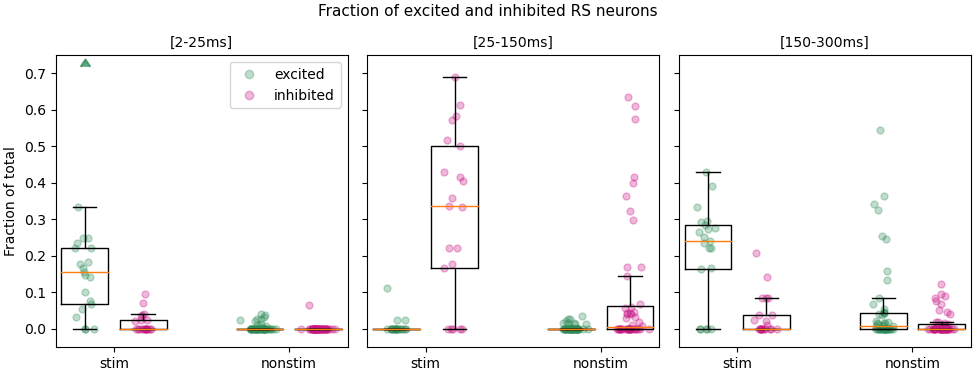

In [24]:
plot_depth = None # superficial, deep, or None=all combined
plot_state = 'awake'
plot_level = 'medium'

fig, axs = plt.subplots(1, 3, figsize=(9.75,3.75), sharex=True, sharey=True, constrained_layout=True)

for ax, windi in zip(axs, response_window.keys()):
    for ii, (labeli, stimTF) in enumerate(ctx_stim.items()):
        if plot_depth:
            df = all_subs_stats_df[
                (all_subs_stats_df['stim_depth'] == plot_depth) &
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
        else:
            df = all_subs_stats_df[
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
        for jj, (resp_type, rcoli) in enumerate(comp.items()):
            unit_fraction = df['num_' + resp_type].values
            xs = np.random.normal(blocs[ii,jj], 0.1, len(unit_fraction))
            ax.boxplot(unit_fraction, positions=[blocs[ii,jj]], widths=[0.8], showfliers=False)
            ax.scatter(xs, unit_fraction, c=rcoli, marker='o', s=25, alpha=0.3)
    ax.set_title('[{:d}-{:d}ms]'.format(int(response_window[windi][0]*1E3), int(response_window[windi][1]*1E3)))
axs[0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[0].set_xticklabels(ctx_stim.keys())
axs[0].set_ylim([-0.05, 1.05])
axs[0].set_ylabel('Fraction of total')

## Plot cut-off data point ##
# axs[0].set_ylim([-0.05, 0.75])
# axs[0].scatter(0, 0.74, c='seagreen', marker=6, s=50, alpha=0.75)

## Legend ##
lhandles = []
for jj, (resp_type, rcoli) in enumerate(comp.items()):
    lhandles.append(Line2D([],[], color=rcoli, linestyle='none', marker='o', markersize=6, alpha=0.3, label=resp_type))
axs[0].legend(handles=lhandles, prop={'size': 10})

plt.suptitle('Fraction of excited and inhibited RS neurons', fontsize=11)

## Save ##
figname = 'allresponses_allmice_stim-nonstim_RS_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Comparing superficial vs. deep stim

<IPython.core.display.Javascript object>


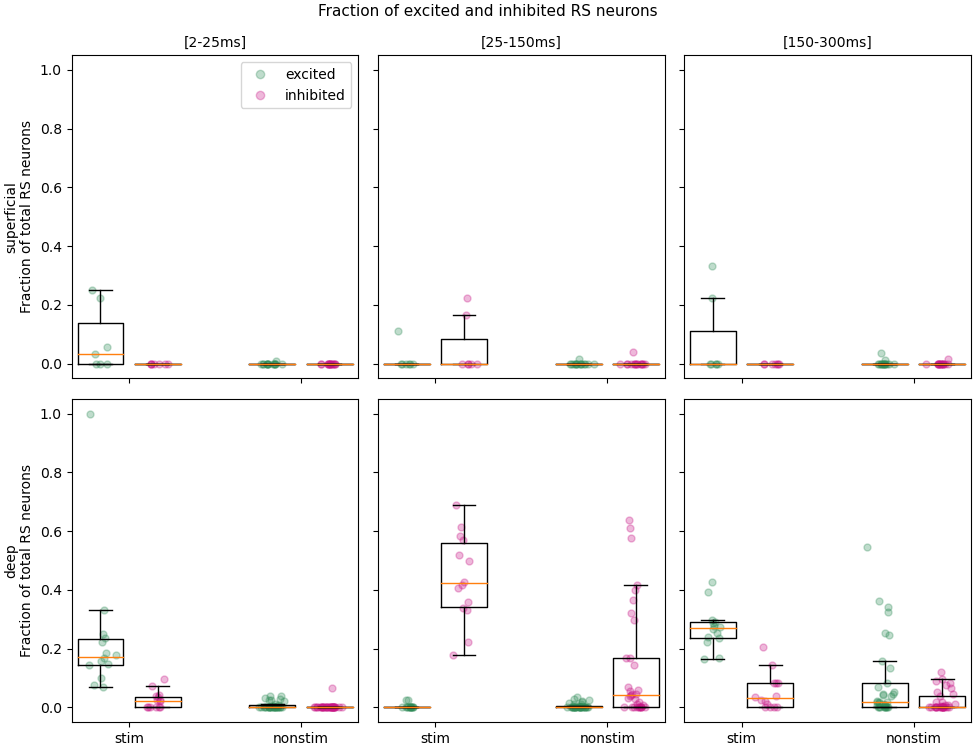

In [29]:
plot_state = 'awake'
plot_level = 'medium'

fig, axs = plt.subplots(2, 3, figsize=(9.75,7.5), sharex=True, sharey=True, constrained_layout=True)

for rowi, depthi in enumerate(['superficial', 'deep']):
    for coli, windi in enumerate(response_window.keys()):
        for ii, (labeli, stimTF) in enumerate(ctx_stim.items()):
            df = all_subs_stats_df[
                (all_subs_stats_df['stim_depth'] == depthi) &
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
            for jj, (resp_type, rcoli) in enumerate(comp.items()):
                unit_fraction = df['num_' + resp_type].values
                xs = np.random.normal(blocs[ii,jj], 0.1, len(unit_fraction))
                axs[rowi,coli].boxplot(unit_fraction, positions=[blocs[ii,jj]], widths=[0.8], showfliers=False)
                axs[rowi,coli].scatter(xs, unit_fraction, c=rcoli, marker='o', s=25, alpha=0.3)
        if rowi == 0:
            axs[rowi,coli].set_title(
                '[{:d}-{:d}ms]'.format(int(response_window[windi][0]*1E3), int(response_window[windi][1]*1E3)))
        if coli == 0:
            axs[rowi,coli].set_ylabel('{}\nFraction of total RS neurons'.format(depthi))
axs[0,0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[0,0].set_xticklabels(ctx_stim.keys())
# axs[0,0].set_ylim([-0.05, 1.05])


## Plot cut-off data point ##
axs[1,0].set_ylim([-0.05, 0.75])
axs[1,0].scatter(0, 0.74, c='seagreen', marker=6, s=50, alpha=0.75)

## Legend ##
lhandles = []
for jj, (resp_type, rcoli) in enumerate(comp.items()):
    lhandles.append(Line2D([],[], color=rcoli, linestyle='none', marker='o', markersize=6, alpha=0.3, label=resp_type))
axs[0,0].legend(handles=lhandles, prop={'size': 10})

plt.suptitle('Fraction of excited and inhibited RS neurons', fontsize=11)

## Save ##
figname = 'CTXunits_sup-deep_stim-nonstim_RS_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Comparing MO vs. SS stim

<IPython.core.display.Javascript object>


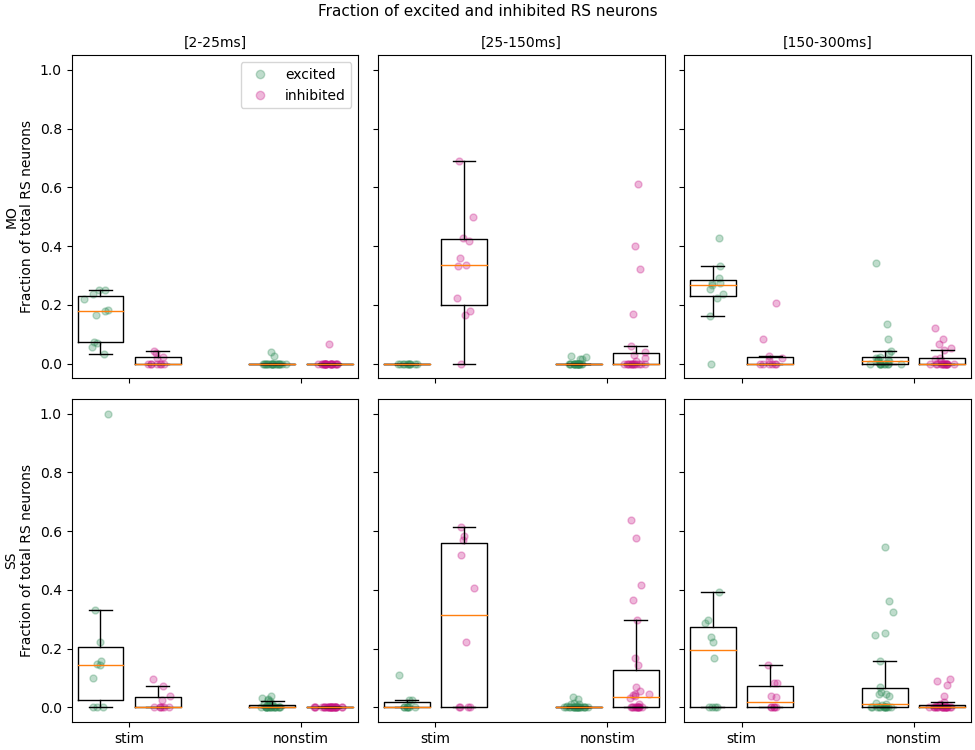

In [30]:
plot_state = 'awake'
plot_level = 'medium'

fig, axs = plt.subplots(2, 3, figsize=(9.75,7.5), sharex=True, sharey=True, constrained_layout=True)

for rowi, stimareai in enumerate(['MO', 'SS']):
    for coli, windi in enumerate(response_window.keys()):
        for ii, (labeli, stimTF) in enumerate(ctx_stim.items()):
            df = all_subs_stats_df[
                (all_subs_stats_df['stim_area'] == stimareai) &
                (all_subs_stats_df['state'] == plot_state) &
                (all_subs_stats_df['stim_cortex'] == stimTF) &
                (all_subs_stats_df['stim_level'] == plot_level) &
                (all_subs_stats_df['window'] == windi)
            ]
            for jj, (resp_type, rcoli) in enumerate(comp.items()):
                unit_fraction = df['num_' + resp_type].values
                xs = np.random.normal(blocs[ii,jj], 0.1, len(unit_fraction))
                axs[rowi,coli].boxplot(unit_fraction, positions=[blocs[ii,jj]], widths=[0.8], showfliers=False)
                axs[rowi,coli].scatter(xs, unit_fraction, c=rcoli, marker='o', s=25, alpha=0.3)
        if rowi == 0:
            axs[rowi,coli].set_title(
                '[{:d}-{:d}ms]'.format(int(response_window[windi][0]*1E3), int(response_window[windi][1]*1E3)))
        if coli == 0:
            axs[rowi,coli].set_ylabel('{}\nFraction of total RS neurons'.format(stimareai))
axs[0,0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[0,0].set_xticklabels(ctx_stim.keys())
# axs[0,0].set_ylim([-0.05, 1.05])


## Plot cut-off data point ##
axs[1,0].set_ylim([-0.05, 0.75])
axs[1,0].scatter(0, 0.74, c='seagreen', marker=6, s=50, alpha=0.75)

## Legend ##
lhandles = []
for jj, (resp_type, rcoli) in enumerate(comp.items()):
    lhandles.append(Line2D([],[], color=rcoli, linestyle='none', marker='o', markersize=6, alpha=0.3, label=resp_type))
axs[0,0].legend(handles=lhandles, prop={'size': 10})

plt.suptitle('Fraction of excited and inhibited RS neurons', fontsize=11)

## Save ##
figname = 'CTXunits_MO-SS_stim-nonstim_RS_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Assemble the figure

In [ ]:
ctx_stim = {'stim': True, 'nonstim': False}
stim_colors = {'stim': 'crimson', 'nonstim': 'black'}

Baseline firing rate

In [ ]:
plot_depth = None # superficial, deep, or None=all combined
plot_state = 'delta'

fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
blocs = np.arange(len(ctx_stim))
for ii, (labeli, stimTF) in enumerate(ctx_stim.items()):
    if plot_depth:
        df = all_subs_info_df[
            (all_subs_info_df['stim_depth'] == plot_depth) &
            (all_subs_info_df['stim_cortex'] == stimTF) &
            (all_subs_info_df['state'] == plot_state)
        ]
    else:
        df = all_subs_info_df[(all_subs_info_df['stim_cortex'] == stimTF) & (all_subs_info_df['state'] == plot_state)]
    
    xs = np.random.normal(blocs[ii], 0.1, len(df))
    ax.boxplot(df['avg_blfr'].values, positions=[blocs[ii]], widths=[0.8], showfliers=False)
    ax.scatter(xs, df['avg_blfr'].values, c=stim_colors[labeli], marker='o', s=25, alpha=0.5)

ax.axhline(0, color='gray', linestyle='dashed', alpha=0.5)
ax.set_xticks(blocs)
ax.set_xticklabels(ctx_stim.keys())
ax.set_ylabel('\u0394AP rate (Hz)')
ax.set_title('Baseline firing rate\n(awake-anesthetized)')

## Save ##
figname = 'baselineFR_allmice_stim-nonstim_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Fraction of responsive cells

In [ ]:
plot_depth = None # 'superficial', 'deep', or None=all combined
plot_level = 'medium'
plot_win = 'late'
resp_type = 'excited'

fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
blocs = np.arange(len(ctx_stim) * (len(test_states) + 1))
blocs = blocs.reshape((len(ctx_stim), (len(test_states) + 1)))
for ii, (labeli, stimTF) in enumerate(ctx_stim.items()):
    if plot_depth:
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_depth'] == plot_depth) &
            (all_subs_stats_df['stim_cortex'] == stimTF) &
            (all_subs_stats_df['stim_level'] == plot_level) &
            (all_subs_stats_df['window'] == plot_win)
        ]
    else:
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_cortex'] == stimTF) &
            (all_subs_stats_df['stim_level'] == plot_level) &
            (all_subs_stats_df['window'] == plot_win)
        ]
    
    ufracts = []
    for jj, statei in enumerate(test_states):
        unit_fraction = df['num_' + resp_type][df['state'] == statei].values
        ufracts.append(unit_fraction)
        xvals = np.full((len(unit_fraction)), blocs[ii,jj])
        ax.plot(xvals, unit_fraction, color=state_colors[statei], marker='o', markersize=8, linestyle='none', alpha=0.75)
    ax.plot(blocs[ii,:-1], np.array(ufracts), color='k', alpha=0.75)
    
ax.set_xticks(np.mean(blocs[:,:-1], axis=1))
ax.set_xticklabels(ctx_stim.keys())
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel('Responsive/Total {} units'.format(plot_units))
ax.set_title('Fraction of {} {} units\n[{:d}-{:d}ms]'.format(
    resp_type, plot_units, int(response_window[plot_win][0]*1E3), int(response_window[plot_win][1]*1E3)))


## Make a legend ##
lhandles = []
for jj, statei in enumerate(test_states):
    lhandles.append(Line2D([],[],color=state_colors[statei],linestyle='none',marker='o',markersize=8,alpha=0.75,label=statei))
ax.legend(handles=lhandles, prop={'size': 9})

## Save ##
figname = 'responsive_allmice_stim-nonstim_{}_{}{}_{}.png'.format(
    plot_win, resp_type, plot_units, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

In [ ]:
df = all_subs_stats_df[
    (all_subs_stats_df['stim_cortex'] == False) &
    (all_subs_stats_df['stim_level'] == 'medium') &
    (all_subs_stats_df['window'] == 'late') &
    (all_subs_stats_df['state'] == 'awake') &
    (all_subs_stats_df['num_excited'] > 0.05)
]

In [ ]:
df

Evoked FR of responsive cells...NEEDS help

In [ ]:
plot_depth = None # superficial, deep, or None=all combined
plot_level = 'medium'
plot_win = 'early'
resp_type = 'excited'

fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
blocs = np.arange(len(ctx_stim) * (len(test_states) + 1))
blocs = blocs.reshape((len(ctx_stim), (len(test_states) + 1)))
for ii, (labeli, stimTF) in enumerate(ctx_stim.items()):
    if plot_depth:
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_depth'] == plot_depth) &
            (all_subs_stats_df['stim_cortex'] == stimTF) &
            (all_subs_stats_df['stim_level'] == plot_level) &
            (all_subs_stats_df['window'] == plot_win)
        ]
    else:
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_cortex'] == stimTF) &
            (all_subs_stats_df['stim_level'] == plot_level) &
            (all_subs_stats_df['window'] == plot_win)
        ]
    
    allFR = []
    for jj, statei in enumerate(test_states):
        FR = df[resp_type + '_FR'][df['state'] == statei].values
        allFR.append(FR)
        xvals = np.full((len(FR)), blocs[ii,jj])
        ax.plot(xvals, FR, color=state_colors[statei], marker='o', markersize=8, linestyle='none', alpha=0.75)
    ax.plot(blocs[ii,:-1], np.array(allFR), color='k', alpha=0.75)
    
ax.set_xticks(np.mean(blocs[:,:-1], axis=1))
ax.set_xticklabels(ctx_stim.keys())
# ax.set_ylim([-0.05, 1.05])
ax.set_ylabel('Responsive/Total {} units'.format(plot_units))
ax.set_title('Evoked firing rate {} {} units\n[{:d}-{:d}ms]'.format(
    resp_type, plot_units, int(response_window[plot_win][0]*1E3), int(response_window[plot_win][1]*1E3)))


## Make a legend ##
lhandles = []
for jj, statei in enumerate(test_states):
    lhandles.append(Line2D([],[],color=state_colors[statei],linestyle='none',marker='o',markersize=8,alpha=0.75,label=statei))
ax.legend(handles=lhandles, prop={'size': 9})

## Save ##
figname = 'responsive_allmice_stim-nonstim_{}_{}{}_{}.png'.format(
    plot_win, resp_type, plot_units, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

In [ ]:
df = all_subs_stats_df[
    (all_subs_stats_df['stim_cortex'] == True) &
    (all_subs_stats_df['stim_level'] == plot_level) &
    (all_subs_stats_df['window'] == plot_win)
]
df.head()

In [ ]:
df

In [ ]:
blocs = np.arange((len(test_states) + 1) * len(areas_of_interest))
blocs = blocs.reshape((len(areas_of_interest), (len(test_states) + 1)))

plt.rc('ytick',labelsize=8)

In [ ]:
## Figure with awake-anesthetized ##
exgroup = 'MOs_deep'
exmouse = '569073'
plot_level = 'medium'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6.5,4), sharex=True, constrained_layout=True)

reg_labels = []
for ri, (region, regdf) in enumerate(regional_metrics.items()):
    blfrs = []
    resp_fr = []
    pfr = []
    for jj, statei in enumerate(test_states):
        exampledf = regdf[
            (regdf['group']==exgroup) & (regdf['mouse']==exmouse) & (regdf['stim_level']==plot_level) & (regdf['state']==statei)
        ]
        mstatedf = regdf[(regdf['stim_level']==plot_level) & (regdf['state']==statei)]
        xloc = blocs[ri, jj]
        ## Plot for single subject ##
        axs[0,0].bar(
            xloc, exampledf['avg_blfr'].values, yerr=exampledf['sem_blfr'].values, width=0.9, color=state_colors[statei]
        )
        axs[0,1].bar(xloc, exampledf['response_fraction'].values, width=0.9, color=state_colors[statei])
        axs[0,2].bar(
            xloc, exampledf['peak_firing_rate'].values, yerr=exampledf['peak_sem'].values,
            width=0.9, color=state_colors[statei]
        )
        
        ## Plot for multi-subject ##
        blfrs.append(mstatedf['avg_blfr'].values)
        resp_fr.append(mstatedf['response_fraction'].values)
        pfr.append(mstatedf['peak_firing_rate'].values)
    
    xposi = np.mean(blocs[ri,:-1])
    xs = np.random.normal(xposi, 0.2, len(mstatedf))
    delta_blfr = blfrs[0] - blfrs[1]
    delta_fract = resp_fr[0] - resp_fr[1]
    delta_peak = pfr[0] - pfr[1]
    
    axs[1,0].boxplot(delta_blfr, positions=[xposi], widths=[2], showfliers=False)
    axs[1,0].scatter(xs, delta_blfr, c='k', marker='o', s=25, alpha=0.5)
    axs[1,1].boxplot(delta_fract, positions=[xposi], widths=[2], showfliers=False)
    axs[1,1].scatter(xs, delta_fract, c='k', marker='o', s=25, alpha=0.5)
    axs[1,2].boxplot(delta_peak, positions=[xposi], widths=[2], showfliers=False)
    axs[1,2].scatter(xs, delta_peak, c='k', marker='o', s=25, alpha=0.5)
    
    reg_labels.append('{}({:d})'.format(region, len(mstatedf)))
    
## Set x-axis labels ##
axs[1,0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1,0].set_xticklabels(reg_labels, fontsize=8, rotation=45)
axs[1,1].set_xticklabels(reg_labels, fontsize=8, rotation=45)
axs[1,2].set_xticklabels(reg_labels, fontsize=8, rotation=45)

## Set y-axis labels ##
axs[0,0].set_ylabel('AP rate (Hz)')
axs[1,0].set_ylabel('\u0394AP rate (Hz)')
axs[0,1].set_ylabel('Fraction of trials')
axs[1,1].set_ylabel('Fraction of trials')
axs[0,2].set_ylabel('AP rate (Hz)')
axs[1,2].set_ylabel('\u0394AP rate (Hz)')

## Set titles ##
axs[0,0].set_title('Baseline firing rate')
axs[0,1].set_title('Trials with response')
axs[0,2].set_title('Evoked firing rate')

## Make a legend ##
barhandles = []
for jj, statei in enumerate(test_states):
    barhandles.append(Patch(color=state_colors[statei], label=statei))
axs[0,0].legend(handles=barhandles, prop={'size': 8})

## Save ##
figname = 'Figure5_popmetrics_allpops_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

# Accumulate data across subjects, cortex only: stim and non-stim

In [ ]:
blocs = np.arange((len(test_states) + 1) * len(popmetrics))
blocs = blocs.reshape((len(popmetrics), (len(test_states) + 1)))

plt.rc('ytick',labelsize=8)

In [ ]:
## Figure with awake-anesthetized, stim vs nonstim ##
exgroup = 'MOs_deep'
exmouse = '569073'
plot_level = 'medium'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6.5,4), sharex=True, constrained_layout=True)

reg_labels = []
for ri, (ctxi, regdf) in enumerate(popmetrics.items()):
    sing_bl, sing_blsem = [], []
    sing_fr = []
    sing_pk, sing_pksem = [], []
    blfrs, resp_fr, pfr = [], [], []
    for jj, statei in enumerate(test_states):
        exampledf = regdf[(
            (regdf['group']==exgroup) & (regdf['mouse']==exmouse) &
            (regdf['stim_level']==plot_level) & (regdf['state']==statei)
        )]
        multidf = regdf[(regdf['stim_level']==plot_level) & (regdf['state']==statei)]
        ## plot for single subject ##
        xlocs = np.full((len(exampledf)), blocs[ri, jj])
        axs[0,0].plot(
            xlocs, exampledf['avg_blfr'].values, color=state_colors[statei], marker='o', markersize=5, linestyle='none'
        )
        sing_bl.append(exampledf['avg_blfr'].values)
        sing_blsem.append(exampledf['sem_blfr'].values)
        axs[0,1].plot(
            xlocs, exampledf['response_fraction'].values, color=state_colors[statei],
            marker='o', markersize=5, linestyle='none'
        )
        sing_fr.append(exampledf['response_fraction'].values)
        axs[0,2].plot(
            xlocs, exampledf['peak_firing_rate'].values, color=state_colors[statei],
            marker='o', markersize=5, linestyle='none'
        )
        sing_pk.append(exampledf['peak_firing_rate'].values)
        sing_pksem.append(exampledf['sem_blfr'].values)
        
        ## Plot for multi-subject ##
        blfrs.append(multidf['avg_blfr'].values)
        resp_fr.append(multidf['response_fraction'].values)
        pfr.append(multidf['peak_firing_rate'].values)
        
    ## plot lines for single subject ##
    for ii in range(np.array(sing_bl).shape[1]):
        axs[0,0].errorbar(blocs[ri,:-1], np.array(sing_bl)[:,ii], yerr=np.array(sing_blsem)[:,ii], color='k')
        axs[0,1].plot(blocs[ri,:-1], np.array(sing_fr)[:,ii], color='k')
        axs[0,2].errorbar(blocs[ri,:-1], np.array(sing_pk)[:,ii], yerr=np.array(sing_pksem)[:,ii], color='k')
    
    ## plot multisubject ##
    xposi = np.mean(blocs[ri,:-1])
    delta_blfr = blfrs[0] - blfrs[1]
    delta_fract = resp_fr[0] - resp_fr[1]
    delta_peak = pfr[0] - pfr[1]
    xs = np.random.normal(xposi, 0.3, len(delta_blfr))
    
    axs[1,0].boxplot(delta_blfr, positions=[xposi], widths=[2], showfliers=False)
    axs[1,0].scatter(xs, delta_blfr, c='k', marker='o', s=25, alpha=0.5)
    axs[1,1].boxplot(delta_fract, positions=[xposi], widths=[2], showfliers=False)
    axs[1,1].scatter(xs, delta_fract, c='k', marker='o', s=25, alpha=0.5)
    axs[1,2].boxplot(delta_peak[~np.isnan(delta_peak)], positions=[xposi], widths=[2], showfliers=False)
    axs[1,2].scatter(xs, delta_peak, c='k', marker='o', s=25, alpha=0.5)
    
    reg_labels.append('{}\n(n={:d})'.format(ctxi, len(mstatedf)))
    
## Set x-axis labels ##
axs[1,0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1,0].set_xticklabels(reg_labels)
# axs[1,1].set_xticklabels(reg_labels)
# axs[1,2].set_xticklabels(reg_labels)

## Set y-axis labels ##
axs[0,0].set_ylabel('AP rate (Hz)')
axs[1,0].set_ylabel('\u0394AP rate (Hz)')
axs[0,1].set_ylabel('Fraction of trials')
axs[1,1].set_ylabel('\u0394Fraction of trials')
axs[0,2].set_ylabel('AP rate (Hz)')
axs[1,2].set_ylabel('\u0394AP rate (Hz)')

## Set titles ##
axs[0,0].set_title('Baseline firing rate')
axs[0,1].set_title('Trials with response')
axs[0,2].set_title('Evoked firing rate')

## Make a legend ##
barhandles = []
for jj, statei in enumerate(test_states):
    barhandles.append(Line2D([], [], color=state_colors[statei], linestyle='none', marker='o', label=statei[:2]))
axs[0,0].legend(handles=barhandles, prop={'size': 8}, loc='upper left') # , prop={'size': 8}

## Save ##
figname = 'Figure5_ctx_RSonly_allmice_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)